<div style="text-align: center;">
    <h1> <font style="bold"> Trabajo Práctico Integrador </font></h1>
    <h2><font style="bold">Visión por Computadora II - CEIA </font></h2>
    <h3><font style="bold">Abril Noguera - Pedro Barrera - Ezequiel Caamaño</font></h3>
    <h4><font style="bold">Explorando para mejorar el baseline</font></h4>
</div>

# Detección Automatizada de Cáncer de Pulmón mediante Visión por Computadora



## 1. Justificaciòn de uso Estrategias Avanzadas

El **diseño del baseline*** cumplió su propósito: lograr un modelo funcional y rápido de entrenar.

Esta aproximación, aunque eficiente, presenta limitaciones, como lo revelaban las métricas obtenidas. 



Para superar las limitaciones del *baseline* y maximizar la precisión en un dominio de alta sensibilidad como el médico, es esencial especializar el modelo. Por ello, hemos diseñado tres estrategias progresivas, enfocadas en mejorar la **especialización del modelo** y su **capacidad de generalización**:

 **1. Data Augmentation Conservador** : Mantiene la extracción de *features* del *baseline* y solo mejora la robustez de los datos de entrenamiento.

 **2. Descongelar Capas + Data Augmentation Moderado**: inclusión de **Fine-Tuning** (`layer4`) y data augmentation más agresivo.

 **3. Entrenamiento en 2 Etapas**:  *Fine-Tuning* progresivo , una técnica más estable y controlada, con el objeto de maximizar estabilidad y lograr convergencia.

### Importación de librerias

Aclaración: En esta oportunidad se selecciona albumentations como librería de Data augmentation por considerarsela más adecuada para datasets de imágenes médicas.

In [17]:
import os
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from torchvision.models import ResNet18_Weights
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
from PIL import Image
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    confusion_matrix, f1_score
)
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from IPython.display import display
import kagglehub


**Configuración**

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
path = os.getenv("DATASET_PATH")
data_dir = os.path.join(path, "Data")
num_classes = 4
batch_size = 32
learning_rate = 1e-3

print(f"Using device: {device}")
print(f"Dataset path: {data_dir}")

Using device: cpu
Dataset path: /Users/ezequiel/.cache/kagglehub/datasets/mohamedhanyyy/chest-ctscan-images/versions/1/Data


**Definición de Clases Auxiliares para Transformación**

Se definen clases necesarias y las distintas transformaciones que se utilizarán

In [19]:
# Clase auxiliar para convertir a RGB
class ToRGB:
    def __call__(self, img):
        return img.convert('RGB')

# Dataset personalizado con Albumentations
class ChestCTDataset(torch.utils.data.Dataset):
    def __init__(self, image_folder_dataset, transform=None):
        self.dataset = image_folder_dataset
        self.transform = transform
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        image = np.array(image)
        
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        
        return image, label

# Transformaciones BASE (sin augmentation)
base_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

# Augmentation CONSERVADOR (recomendado para CT médicos)
conservative_transform = A.Compose([
    A.Resize(224, 224),
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(
        shift_limit=0.05,
        scale_limit=0.05,
        rotate_limit=5,
        p=0.3
    ),
    A.RandomBrightnessContrast(
        brightness_limit=0.1,
        contrast_limit=0.1,
        p=0.3
    ),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

# Augmentation MODERADO
moderate_transform = A.Compose([
    A.Resize(224, 224),
    A.RandomRotate90(p=0.3),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(
        shift_limit=0.0625,
        scale_limit=0.1,
        rotate_limit=10,
        p=0.4
    ),
    A.RandomBrightnessContrast(
        brightness_limit=0.15,
        contrast_limit=0.15,
        p=0.4
    ),
    A.GaussNoise(var_limit=(10.0, 30.0), p=0.2),
    A.GaussianBlur(blur_limit=(3, 5), p=0.2),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

/opt/anaconda3/envs/mi_proyecto_env/lib/python3.11/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/var/folders/tl/xglkhb5171d5q1w_9pqd1ldr0000gp/T/ipykernel_17872/406378489.py:68: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 30.0), p=0.2),


# Carga y preparación de datos finales. Definición de funciones auxiliares para Transfer Learning, evaluación y entrenamiento.



In [ ]:
minimal_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    ToRGB()
])

train_base = datasets.ImageFolder(
    os.path.join(data_dir, "train"),
    transform=minimal_transform
)
valid_base = datasets.ImageFolder(
    os.path.join(data_dir, "valid"),
    transform=minimal_transform
)
test_base = datasets.ImageFolder(
    os.path.join(data_dir, "test"),
    transform=minimal_transform
)

class_names = train_base.classes

# Crear datasets con diferentes niveles de augmentation
valid_dataset = ChestCTDataset(valid_base, transform=base_transform)
test_dataset = ChestCTDataset(test_base, transform=base_transform)

valid_loader = DataLoader(valid_dataset, batch_size=batch_size, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=0)

print(f"\nTamaño dataset train: {len(train_base)}")
print(f"Tamaño dataset valid: {len(valid_dataset)}")
print(f"Tamaño dataset test: {len(test_dataset)}")
print(f"Clases: {class_names}")

# Funciones auxiliares
def crear_modelo():
    model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
    for param in model.parameters():
        param.requires_grad = False
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    model = model.to(device)
    return model

def crear_modelo_unfrozen(num_layers_to_unfreeze=1):
    model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
    
    for param in model.parameters():
        param.requires_grad = False
    
    if num_layers_to_unfreeze >= 1:
        for param in model.layer4.parameters():
            param.requires_grad = True
    
    if num_layers_to_unfreeze >= 2:
        for param in model.layer3.parameters():
            param.requires_grad = True
    
    if num_layers_to_unfreeze >= 3:
        for param in model.layer2.parameters():
            param.requires_grad = True
    
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    model = model.to(device)
    
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total_params = sum(p.numel() for p in model.parameters())
    
    print(f"Parámetros entrenables: {trainable_params:,} / {total_params:,}")
    print(f"Porcentaje entrenable: {100 * trainable_params / total_params:.2f}%")
    
    return model

def evaluar_acc(modelo, dataloader):
    modelo.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            outputs = modelo(x)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    return acc

def metricas(modelo, dataloader, class_names, zero_division=0):
    modelo.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            outputs = modelo(x)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    overall_accuracy = accuracy_score(all_labels, all_preds)

    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels,
        all_preds,
        average=None,
        zero_division=zero_division,
    )

    cm = confusion_matrix(all_labels, all_preds)
    total_samples = cm.sum()

    per_class_rows = []
    for idx, name in enumerate(class_names):
        tp = cm[idx, idx]
        fp = cm[:, idx].sum() - tp
        fn = cm[idx, :].sum() - tp
        tn = total_samples - (tp + fp + fn)

        specificity = tn / (tn + fp) if (tn + fp) > 0 else zero_division
        class_accuracy = (tp + tn) / total_samples if total_samples > 0 else 0.0

        per_class_rows.append({
            "clase": name,
            "accuracy": float(class_accuracy),
            "precision": float(precision[idx]),
            "sensibilidad": float(recall[idx]),
            "especificidad": float(specificity),
            "f1": float(f1[idx]),
        })

    metrics_df = pd.DataFrame(per_class_rows).set_index("clase")

    overall_f1 = f1_score(
        all_labels,
        all_preds,
        average="macro",
        zero_division=zero_division,
    )

    globales = {
        "accuracy_global": float(overall_accuracy),
        "f1_global": float(overall_f1),
    }

    return metrics_df, globales, cm

def plot_cm(cm, classes, normalize='true', title="Matriz de confusión"):
    if normalize is None:
        cm_to_plot = cm
        values_format = "d"
    elif normalize == "true":
        cm_to_plot = cm.astype(float) / cm.sum(axis=1, keepdims=True)
        values_format = ".2f"
    elif normalize == "pred":
        cm_to_plot = cm.astype(float) / cm.sum(axis=0, keepdims=True)
        values_format = ".2f"
    elif normalize == "all":
        cm_to_plot = cm.astype(float) / cm.sum()
        values_format = ".2f"
    else:
        raise ValueError("normalize debe ser None, 'true', 'pred' o 'all'.")

    fig, ax = plt.subplots(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_to_plot, display_labels=classes)
    disp.plot(include_values=True, ax=ax, colorbar=True, values_format=values_format)
    title_suffix = "" if normalize is None else " (normalizada)"
    ax.set_title(f"{title}{title_suffix}")
    plt.tight_layout()
    plt.show()

def analizar_dataset(dataset):
    class_counts = {}
    total = 0
    
    for _, label in dataset.dataset:
        class_counts[label] = class_counts.get(label, 0) + 1
        total += 1
    
    print("\n" + "="*60)
    print("ANÁLISIS DE BALANCE DE CLASES")
    print("="*60)
    
    for class_idx in sorted(class_counts.keys()):
        count = class_counts[class_idx]
        percentage = 100 * count / total
        print(f"Clase {class_names[class_idx]}: {count:4d} muestras ({percentage:5.2f}%)")
    
    if max(class_counts.values()) / min(class_counts.values()) > 1.5:
        print("\n⚠️ Dataset desbalanceado detectado!")
        print("Calculando pesos para balancear...")
        
        weights = []
        for i in range(len(class_counts)):
            weights.append(total / (len(class_counts) * class_counts[i]))
        
        print("Pesos por clase:", [f"{w:.2f}" for w in weights])
        return torch.tensor(weights, dtype=torch.float).to(device)
    
    print("\n✅ Dataset balanceado")
    return None

def entrenar_modelo_mejorado(model, train_loader, valid_loader, num_epochs, model_name,
                             use_scheduler=True, patience=5, class_weights=None):
    if class_weights is not None:
        criterion = nn.CrossEntropyLoss(weight=class_weights)
    else:
        criterion = nn.CrossEntropyLoss()
    
    params_to_update = []
    for name, param in model.named_parameters():
        if param.requires_grad:
            if 'fc' in name:
                params_to_update.append({'params': param, 'lr': learning_rate})
            else:
                params_to_update.append({'params': param, 'lr': learning_rate * 0.1})
    
    optimizer = Adam(params_to_update)
    
    if use_scheduler:
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='max', factor=0.5, patience=2, verbose=True
        )
    
    history = {
        'train_acc': [],
        'val_acc': [],
        'train_loss': [],
        'val_loss': []
    }
    
    best_val_acc = 0.0
    patience_counter = 0
    
    print(f"\n{'='*60}")
    print(f"ENTRENAMIENTO: {model_name}")
    print(f"{'='*60}")
    
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()

        model.eval()
        val_loss = 0.0
        all_preds, all_labels = [], []
        
        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                preds = torch.argmax(outputs, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        train_acc = evaluar_acc(model, train_loader)
        val_acc = accuracy_score(all_labels, all_preds)
        avg_train_loss = epoch_loss / len(train_loader)
        avg_val_loss = val_loss / len(valid_loader)
        
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        
        print(f"Epoch {epoch + 1}/{num_epochs} | "
              f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | "
              f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")
        
        if use_scheduler:
            scheduler.step(val_acc)
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            torch.save(model.state_dict(), f"Output/{model_name.replace(' ', '_')}_best.pth")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"\n⚠️ Early stopping activado en época {epoch + 1}")
                print(f"Mejor Val Acc: {best_val_acc:.4f}")
                break
    
    model.load_state_dict(torch.load(f"Output/{model_name.replace(' ', '_')}_best.pth", map_location=device))
    
    return history, best_val_acc


Tamaño dataset train: 613
Tamaño dataset valid: 72
Tamaño dataset test: 315
Clases: ['adenocarcinoma', 'large.cell.carcinoma', 'normal', 'squamous.cell.carcinoma']


# Estrategia 1: Data Augmentation Conservador
La estrategia consiste en aplicar un aumento de datos conservador al conjunto de entrenamiento y luego entrenar solo la capa final del modelo base (ResNet18).


ESTRATEGIA 1: DATA AUGMENTATION CONSERVADOR

ANÁLISIS DE BALANCE DE CLASES
Clase adenocarcinoma:  195 muestras (31.81%)
Clase large.cell.carcinoma:  115 muestras (18.76%)
Clase normal:  148 muestras (24.14%)
Clase squamous.cell.carcinoma:  155 muestras (25.29%)

⚠️ Dataset desbalanceado detectado!
Calculando pesos para balancear...
Pesos por clase: ['0.79', '1.33', '1.04', '0.99']

ENTRENAMIENTO: Modelo_Conservador


/opt/anaconda3/envs/mi_proyecto_env/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/15 | Train Loss: 1.1892 | Val Loss: 1.0984 | Train Acc: 0.4339 | Val Acc: 0.4583
Epoch 2/15 | Train Loss: 0.9255 | Val Loss: 0.9189 | Train Acc: 0.5498 | Val Acc: 0.4583
Epoch 3/15 | Train Loss: 0.8698 | Val Loss: 0.8396 | Train Acc: 0.6835 | Val Acc: 0.5556
Epoch 4/15 | Train Loss: 0.7627 | Val Loss: 0.8365 | Train Acc: 0.7716 | Val Acc: 0.6667
Epoch 5/15 | Train Loss: 0.7010 | Val Loss: 0.8681 | Train Acc: 0.7439 | Val Acc: 0.6667
Epoch 6/15 | Train Loss: 0.7145 | Val Loss: 0.8337 | Train Acc: 0.7374 | Val Acc: 0.6250
Epoch 7/15 | Train Loss: 0.7054 | Val Loss: 0.7581 | Train Acc: 0.8140 | Val Acc: 0.6389
Epoch 8/15 | Train Loss: 0.6428 | Val Loss: 0.7659 | Train Acc: 0.8271 | Val Acc: 0.6389
Epoch 9/15 | Train Loss: 0.6177 | Val Loss: 0.7741 | Train Acc: 0.8075 | Val Acc: 0.6667

⚠️ Early stopping activado en época 9
Mejor Val Acc: 0.6667

EVALUACIÓN: MODELO CONSERVADOR


/var/folders/tl/xglkhb5171d5q1w_9pqd1ldr0000gp/T/ipykernel_17872/922125424.py:295: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"{model_na


MÉTRICAS POR CLASE:


,accuracy,precision,sensibilidad,especificidad,f1
clase,,,,,
adenocarcinoma,0.720635,0.673913,0.516667,0.846154,0.584906
large.cell.carcinoma,0.784127,0.412371,0.784314,0.784091,0.540541
normal,1.000000,1.000000,1.000000,1.000000,1.000000
squamous.cell.carcinoma,0.771429,0.625000,0.500000,0.880000,0.555556



Accuracy Global: 0.6381
F1 Global (macro): 0.6703


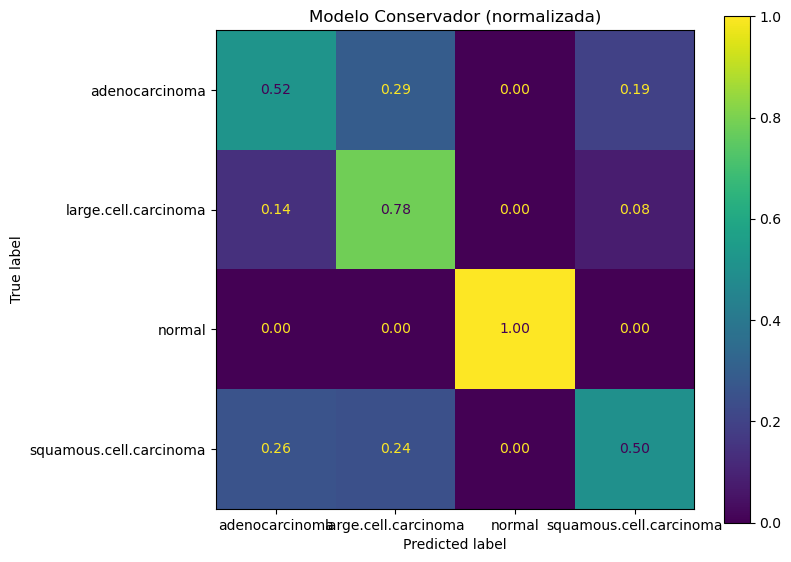

In [ ]:
print("\n" + "="*80)
print("ESTRATEGIA 1: DATA AUGMENTATION CONSERVADOR")
print("="*80)

train_conservative = ChestCTDataset(train_base, transform=conservative_transform)
train_loader_conservative = DataLoader(
    train_conservative,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0
)

class_weights = analizar_dataset(train_conservative)

model_conservative = crear_modelo()
history_conservative, best_val_conservative = entrenar_modelo_mejorado(
    model_conservative,
    train_loader_conservative,
    valid_loader,
    num_epochs=15,
    model_name="Modelo_Conservador",
    use_scheduler=True,
    class_weights=class_weights
)

print("\n" + "="*80)
print("EVALUACIÓN: MODELO CONSERVADOR")
print("="*80)

metrics_conservative, globales_conservative, cm_conservative = metricas(
    model_conservative,
    test_loader,
    class_names
)

print("\nMÉTRICAS POR CLASE:")
display(metrics_conservative)
print(f"\nAccuracy Global: {globales_conservative['accuracy_global']:.4f}")
print(f"F1 Global (macro): {globales_conservative['f1_global']:.4f}")

plot_cm(cm_conservative, class_names, title="Modelo Conservador")

torch.save(model_conservative.state_dict(), "Output/modelo_conservador.pth")



# ESTRATEGIA 2: Descongelar capas y Data Augmentation Moderado. Aplicación de Fine Tunning

Además de reemplazar y entrenar la capa FC, también descongela el último bloque de capas convolucionales (layer4) y aumentamos el número de épocas. 




ESTRATEGIA 2: DESCONGELAR CAPAS Y DATA AUGMENTATION MODERADO
Parámetros entrenables: 8,395,780 / 11,178,564
Porcentaje entrenable: 75.11%

ENTRENAMIENTO: Modelo_Unfrozen


/opt/anaconda3/envs/mi_proyecto_env/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/20 | Train Loss: 1.0620 | Val Loss: 0.9004 | Train Acc: 0.6460 | Val Acc: 0.5556
Epoch 2/20 | Train Loss: 0.7338 | Val Loss: 0.7531 | Train Acc: 0.6868 | Val Acc: 0.6389
Epoch 3/20 | Train Loss: 0.6441 | Val Loss: 0.7370 | Train Acc: 0.7635 | Val Acc: 0.7083
Epoch 4/20 | Train Loss: 0.5508 | Val Loss: 0.5669 | Train Acc: 0.8059 | Val Acc: 0.7917
Epoch 5/20 | Train Loss: 0.4956 | Val Loss: 0.8179 | Train Acc: 0.7814 | Val Acc: 0.7500
Epoch 6/20 | Train Loss: 0.4533 | Val Loss: 0.6132 | Train Acc: 0.8303 | Val Acc: 0.8056
Epoch 7/20 | Train Loss: 0.4072 | Val Loss: 0.6596 | Train Acc: 0.8157 | Val Acc: 0.7917
Epoch 8/20 | Train Loss: 0.3833 | Val Loss: 0.5918 | Train Acc: 0.8450 | Val Acc: 0.7917
Epoch 9/20 | Train Loss: 0.3677 | Val Loss: 0.5046 | Train Acc: 0.8793 | Val Acc: 0.8611
Epoch 10/20 | Train Loss: 0.3953 | Val Loss: 0.5923 | Train Acc: 0.8662 | Val Acc: 0.8611
Epoch 11/20 | Train Loss: 0.4156 | Val Loss: 0.5971 | Train Acc: 0.8418 | Val Acc: 0.8056
Epoch 12/20 | Train

/var/folders/tl/xglkhb5171d5q1w_9pqd1ldr0000gp/T/ipykernel_17872/922125424.py:295: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"{model_na


MÉTRICAS POR CLASE:


,accuracy,precision,sensibilidad,especificidad,f1
clase,,,,,
adenocarcinoma,0.869841,0.796992,0.883333,0.861538,0.837945
large.cell.carcinoma,0.936508,0.918919,0.666667,0.988636,0.772727
normal,0.996825,1.000000,0.981481,1.000000,0.990654
squamous.cell.carcinoma,0.917460,0.847826,0.866667,0.937778,0.857143



Accuracy Global: 0.8603
F1 Global (macro): 0.8646


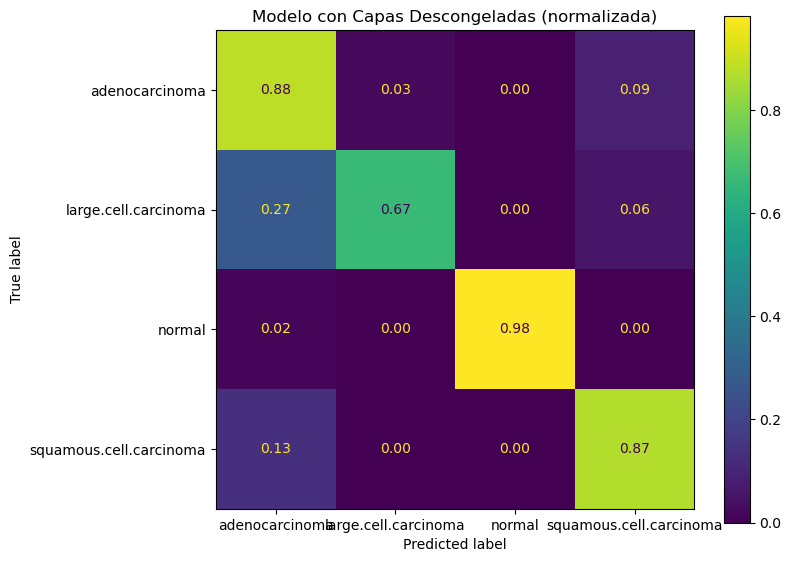

In [ ]:
print("\n" + "="*80)
print("ESTRATEGIA 2: DESCONGELAR CAPAS Y DATA AUGMENTATION MODERADO")
print("="*80)

train_moderate = ChestCTDataset(train_base, transform=moderate_transform)
train_loader_moderate = DataLoader(
    train_moderate,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0
)

model_unfrozen = crear_modelo_unfrozen(num_layers_to_unfreeze=1)
history_unfrozen, best_val_unfrozen = entrenar_modelo_mejorado(
    model_unfrozen,
    train_loader_moderate,
    valid_loader,
    num_epochs=20,
    model_name="Modelo_Unfrozen",
    use_scheduler=True,
    class_weights=class_weights
)

print("\n" + "="*80)
print("EVALUACIÓN: MODELO CON CAPAS DESCONGELADAS")
print("="*80)

metrics_unfrozen, globales_unfrozen, cm_unfrozen = metricas(
    model_unfrozen,
    test_loader,
    class_names
)

print("\nMÉTRICAS POR CLASE:")
display(metrics_unfrozen)
print(f"\nAccuracy Global: {globales_unfrozen['accuracy_global']:.4f}")
print(f"F1 Global (macro): {globales_unfrozen['f1_global']:.4f}")

plot_cm(cm_unfrozen, class_names, title="Modelo con Capas Descongeladas")

torch.save(model_unfrozen.state_dict(), "Output/modelo_unfrozen.pth")


# ESTRATEGIA 3: Entrenamiento en 2 Etapas

Se hace un primer entrenamiento con todas las capas congeladas. En la segunda etapa se descongela layer 4, se utilizan 15 épocas. 


ESTRATEGIA 3: ENTRENAMIENTO EN 2 ETAPAS

ETAPA 1: Solo capa final

ENTRENAMIENTO: Etapa_1
Epoch 1/10 | Train Loss: 1.2432 | Val Loss: 1.1692 | Train Acc: 0.3850 | Val Acc: 0.3750
Epoch 2/10 | Train Loss: 1.0205 | Val Loss: 0.9775 | Train Acc: 0.5595 | Val Acc: 0.5556
Epoch 3/10 | Train Loss: 0.8814 | Val Loss: 0.8594 | Train Acc: 0.6917 | Val Acc: 0.5417
Epoch 4/10 | Train Loss: 0.7946 | Val Loss: 0.8532 | Train Acc: 0.7243 | Val Acc: 0.5556
Epoch 5/10 | Train Loss: 0.7135 | Val Loss: 0.8635 | Train Acc: 0.6884 | Val Acc: 0.4583
Epoch 6/10 | Train Loss: 0.7225 | Val Loss: 0.8101 | Train Acc: 0.7814 | Val Acc: 0.5556
Epoch 7/10 | Train Loss: 0.6693 | Val Loss: 0.8621 | Train Acc: 0.7847 | Val Acc: 0.6806
Epoch 8/10 | Train Loss: 0.6732 | Val Loss: 0.7908 | Train Acc: 0.8254 | Val Acc: 0.6111
Epoch 9/10 | Train Loss: 0.6210 | Val Loss: 0.7577 | Train Acc: 0.7928 | Val Acc: 0.6250
Epoch 10/10 | Train Loss: 0.5886 | Val Loss: 0.7404 | Train Acc: 0.7684 | Val Acc: 0.6389

ETAPA 2: Fine-tun

/var/folders/tl/xglkhb5171d5q1w_9pqd1ldr0000gp/T/ipykernel_17872/922125424.py:295: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"{model_na

Epoch 1/15 | Train Loss: 0.5262 | Val Loss: 0.6640 | Train Acc: 0.9266 | Val Acc: 0.7083
Epoch 2/15 | Train Loss: 0.2042 | Val Loss: 0.4770 | Train Acc: 0.9918 | Val Acc: 0.8194
Epoch 3/15 | Train Loss: 0.1793 | Val Loss: 0.5754 | Train Acc: 0.9869 | Val Acc: 0.8056
Epoch 4/15 | Train Loss: 0.0932 | Val Loss: 0.4557 | Train Acc: 0.9984 | Val Acc: 0.8472
Epoch 5/15 | Train Loss: 0.0429 | Val Loss: 0.3998 | Train Acc: 0.9935 | Val Acc: 0.8611
Epoch 6/15 | Train Loss: 0.0390 | Val Loss: 0.3596 | Train Acc: 0.9967 | Val Acc: 0.8611
Epoch 7/15 | Train Loss: 0.0256 | Val Loss: 0.4353 | Train Acc: 0.9967 | Val Acc: 0.8611
Epoch 8/15 | Train Loss: 0.0521 | Val Loss: 0.4391 | Train Acc: 1.0000 | Val Acc: 0.8611
Epoch 9/15 | Train Loss: 0.2031 | Val Loss: 0.4492 | Train Acc: 0.9837 | Val Acc: 0.8472
Epoch 10/15 | Train Loss: 0.0653 | Val Loss: 0.4775 | Train Acc: 0.9935 | Val Acc: 0.8472

⚠️ Early stopping activado en época 10
Mejor Val Acc: 0.8611

EVALUACIÓN: MODELO 2 ETAPAS


/var/folders/tl/xglkhb5171d5q1w_9pqd1ldr0000gp/T/ipykernel_17872/922125424.py:295: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"{model_na


MÉTRICAS POR CLASE:


,accuracy,precision,sensibilidad,especificidad,f1
clase,,,,,
adenocarcinoma,0.879365,0.901961,0.766667,0.948718,0.828829
large.cell.carcinoma,0.920635,0.671053,1.000000,0.905303,0.803150
normal,0.996825,1.000000,0.981481,1.000000,0.990654
squamous.cell.carcinoma,0.936508,0.916667,0.855556,0.968889,0.885057



Accuracy Global: 0.8667
F1 Global (macro): 0.8769


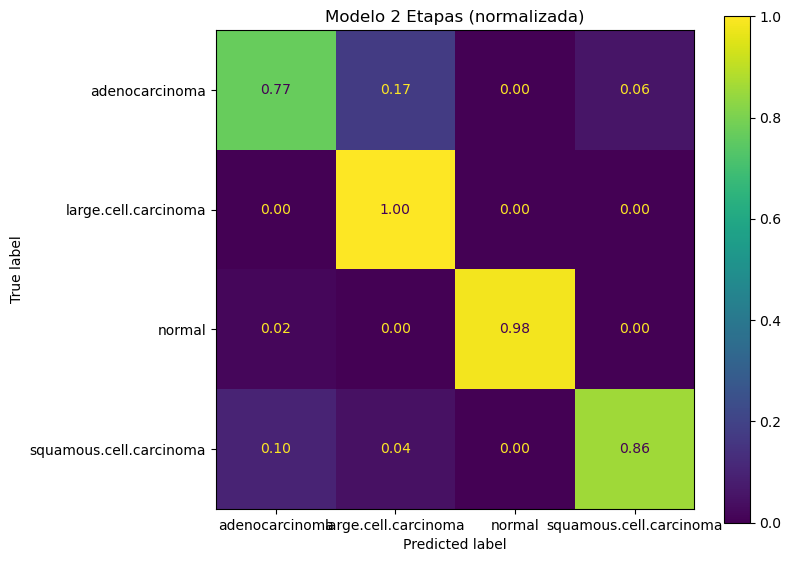

In [ ]:
print("\n" + "="*80)
print("ESTRATEGIA 3: ENTRENAMIENTO EN 2 ETAPAS")
print("="*80)

print("\nETAPA 1: Solo capa final")
model_2stages = crear_modelo()
history_stage1, _ = entrenar_modelo_mejorado(
    model_2stages,
    train_loader_conservative,
    valid_loader,
    num_epochs=10,
    model_name="Etapa_1",
    use_scheduler=False,
    patience=5,
    class_weights=class_weights
)

print("\nETAPA 2: Fine-tuning con layer4 descongelado")
for param in model_2stages.layer4.parameters():
    param.requires_grad = True

history_stage2, best_val_2stages = entrenar_modelo_mejorado(
    model_2stages,
    train_loader_conservative,
    valid_loader,
    num_epochs=15,
    model_name="Etapa_2",
    use_scheduler=True,
    patience=5,
    class_weights=class_weights
)

print("\n" + "="*80)
print("EVALUACIÓN: MODELO 2 ETAPAS")
print("="*80)

metrics_2stages, globales_2stages, cm_2stages = metricas(
    model_2stages,
    test_loader,
    class_names
)

print("\nMÉTRICAS POR CLASE:")
display(metrics_2stages)
print(f"\nAccuracy Global: {globales_2stages['accuracy_global']:.4f}")
print(f"F1 Global (macro): {globales_2stages['f1_global']:.4f}")

plot_cm(cm_2stages, class_names, title="Modelo 2 Etapas")

torch.save(model_2stages.state_dict(), "Output/modelo_2_etapas.pth")



# COMPARACIÓN FINAL CON BASELINE
Comparamos el baseline con las distintas estrategias utilizadas


COMPARACIÓN FINAL: TODAS LAS ESTRATEGIAS VS BASELINE


/var/folders/tl/xglkhb5171d5q1w_9pqd1ldr0000gp/T/ipykernel_17872/554475772.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_baseline.load_state_dict(torch.load("ba


MÉTRICAS BASELINE:


,accuracy,precision,sensibilidad,especificidad,f1
clase,,,,,
adenocarcinoma,0.622222,0.503597,0.583333,0.646154,0.540541
large.cell.carcinoma,0.822222,0.272727,0.058824,0.969697,0.096774
normal,0.965079,0.957447,0.833333,0.992337,0.891089
squamous.cell.carcinoma,0.612698,0.364407,0.477778,0.666667,0.413462


Accuracy: 0.5111
F1-Score: 0.4855


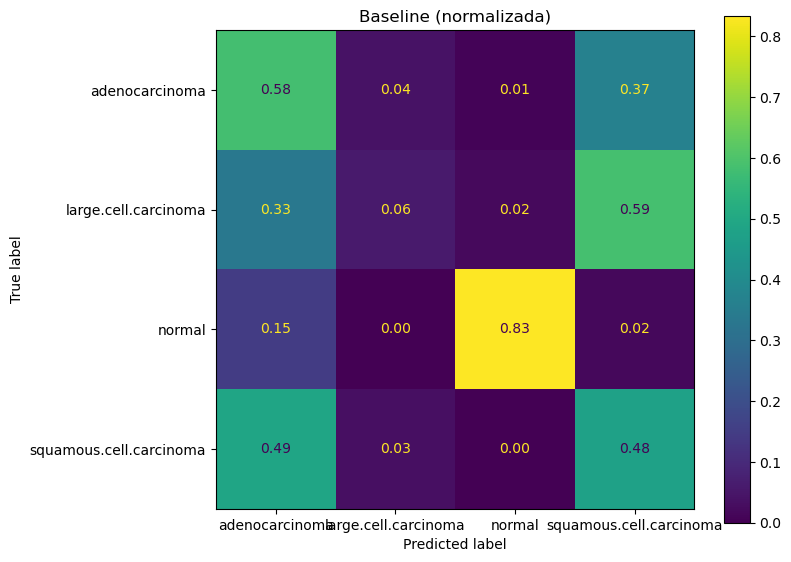


TABLA COMPARATIVA


,Accuracy,F1-Score
Estrategia 1 (Conservador),0.638095,0.670250
Estrategia 2 (Unfrozen),0.860317,0.864617
Estrategia 3 (2 Etapas),0.866667,0.876923
Baseline,0.511111,0.485466


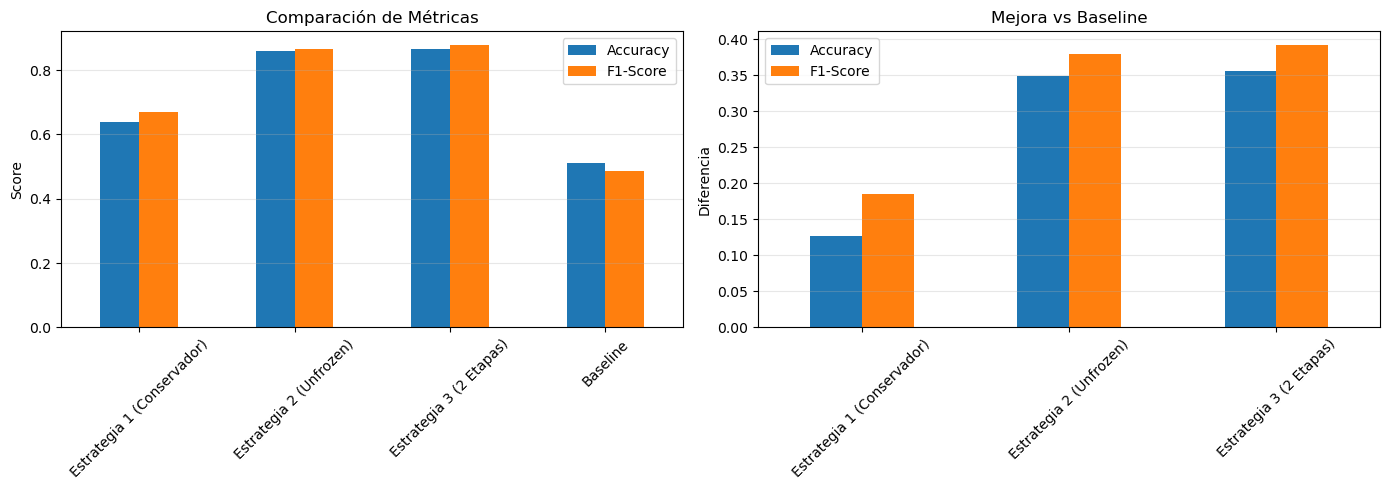


🏆 MEJOR ESTRATEGIA: Estrategia 3 (2 Etapas)
   Accuracy: 0.8667
   F1-Score: 0.8769

   Mejora en Accuracy: +35.56%
   Mejora en F1-Score: +39.15%

✅ Proceso completado!


In [ ]:
print("\n" + "="*80)
print("COMPARACIÓN FINAL: TODAS LAS ESTRATEGIAS VS BASELINE")
print("="*80)

resultados = {
    'Estrategia 1 (Conservador)': globales_conservative,
    'Estrategia 2 (Unfrozen)': globales_unfrozen,
    'Estrategia 3 (2 Etapas)': globales_2stages
}

if os.path.exists("Output/baseline_model.pth"):
    model_baseline = crear_modelo()
    model_baseline.load_state_dict(torch.load("Output/baseline_model.pth", map_location=device))
    metrics_base, globales_base, cm_base = metricas(model_baseline, test_loader, class_names)
    resultados['Baseline'] = globales_base
    
    print("\nMÉTRICAS BASELINE:")
    display(metrics_base)
    print(f"Accuracy: {globales_base['accuracy_global']:.4f}")
    print(f"F1-Score: {globales_base['f1_global']:.4f}")
    
    plot_cm(cm_base, class_names, title="Baseline")

comparison_df = pd.DataFrame({
    'Accuracy': [r['accuracy_global'] for r in resultados.values()],
    'F1-Score': [r['f1_global'] for r in resultados.values()]
}, index=resultados.keys())

print("\n" + "="*80)
print("TABLA COMPARATIVA")
print("="*80)
display(comparison_df)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

comparison_df.plot(kind='bar', ax=axes[0], rot=45)
axes[0].set_title('Comparación de Métricas')
axes[0].set_ylabel('Score')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

if os.path.exists("Output/baseline_model.pth"):
    mejoras = pd.DataFrame({
        'Accuracy': [r['accuracy_global'] - globales_base['accuracy_global'] for k, r in resultados.items() if k != 'Baseline'],
        'F1-Score': [r['f1_global'] - globales_base['f1_global'] for k, r in resultados.items() if k != 'Baseline']
    }, index=[k for k in resultados.keys() if k != 'Baseline'])
    
    mejoras.plot(kind='bar', ax=axes[1], rot=45)
    axes[1].set_title('Mejora vs Baseline')
    axes[1].set_ylabel('Diferencia')
    axes[1].axhline(y=0, color='black', linestyle='--', linewidth=0.5)
    axes[1].legend()
    axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

mejor_estrategia = max(resultados.items(), key=lambda x: x[1]['accuracy_global'])
print(f"\n🏆 MEJOR ESTRATEGIA: {mejor_estrategia[0]}")
print(f"   Accuracy: {mejor_estrategia[1]['accuracy_global']:.4f}")
print(f"   F1-Score: {mejor_estrategia[1]['f1_global']:.4f}")

if os.path.exists("Output/baseline_model.pth"):
    mejora_acc = (mejor_estrategia[1]['accuracy_global'] - globales_base['accuracy_global']) * 100
    mejora_f1 = (mejor_estrategia[1]['f1_global'] - globales_base['f1_global']) * 100
    print(f"\n   Mejora en Accuracy: {mejora_acc:+.2f}%")
    print(f"   Mejora en F1-Score: {mejora_f1:+.2f}%")

print("\n✅ Proceso completado!")

## Conclusiones

La tabla de resultados es muy clara. Confirma que la **Estrategia 3** es la de mejor rendimiento, aunque la ganancia respecto a la **Estrategia 2** es marginal.


El salto de rendimiento más significativo se da al pasar de la **Extracción de Características** (Estrategia 1: 67.03% F1) a las estrategias que implementan el **Fine-Tuning** (Estrategia 2 y 3, que superan el 86% F1).

  * **Impacto:** El **Fine-Tuning** de la capa convolucional superior (`layer4`) es el factor más crucial. Demuestra que las características genéricas aprendidas no son suficientes para las imágenes médicas (CT de tórax), y que es obligatorio **especializar** el extractor de *features* para capturar los patrones clínicos relevantes.
  * **Recomendación:** Cualquier modelo para este dominio debe incluir **Fine-Tuning** y no solo entrenar la capa final.

Por otra parte, hay que destacar **Estrategia 3 (Entrenamiento en 2 Etapas)** es marginalmente superior a la Estrategia 2 (Fine-Tuning directo):

  * **Ganancia en F1-Score:** La Estrategia 3 ofrece una mejora de aproximadamente **1.2 puntos porcentuales** en el F1-Score.
  * **Estabilidad:** Esta pequeña ganancia se obtiene a través de un proceso más riguroso y estable. El entrenamiento en dos etapas asegura que la capa final **FC** converja primero de manera óptima, estableciendo una base, antes de iniciar el ajuste fino de las capas convolucionales (con tasas de aprendizaje más bajas). Esto minimiza el riesgo de corromper los pesos preentrenados de ResNet18 y explica la ligera pero constante superioridad.

La **Estrategia 3** debe ser considerada el **Modelo Final** de producción. Ofrece el mayor **F1-Score (87.69%)**, que es la métrica más robusta para evaluar la clasificación en *datasets* potencialmente desbalanceados, y lo hace a través de una metodología de entrenamiento más estable.

Si el costo computacional fuera una limitación, la Estrategia 2 sería una alternativa válida, ya que su rendimiento es muy cercano, pero la Estrategia 3 es la mejor opción en términos de precisión.